#  DATA EXPLORATORY ANALYSIS AND HYPOTHESIS TESTING FOR INSURANCE CLAIMS DATA

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ttest_1samp, chi2_contingency, f_oneway, pearsonr

### 1.Import claims_data.csv and cust_data.csv which is provided to you and combine the two datasets appropriately to create a 360-degree view of the data. Use the same for the subsequent questions

In [2]:
claims_data = pd.read_csv('claims.csv')
cust_data = pd.read_csv('cust_demographics.csv')
print(claims_data.head())
print(cust_data.head())

   claim_id  customer_id      incident_cause  claim_date claim_area  \
0  54004764     21868593        Driver error  11/27/2017       Auto   
1  33985796     75740424               Crime  10/03/2018       Home   
2  53522022     30308357  Other driver error  02/02/2018       Auto   
3  13015401     47830476      Natural causes  06/17/2018       Auto   
4  22890252     19269962               Crime  01/13/2018       Auto   

  police_report     claim_type claim_amount  total_policy_claims fraudulent  
0            No  Material only        $2980                  1.0         No  
1       Unknown  Material only        $2980                  3.0         No  
2            No  Material only      $3369.5                  1.0        Yes  
3            No  Material only        $1680                  1.0         No  
4            No  Material only        $2680                  1.0         No  
    CUST_ID  gender DateOfBirth State       Contact   Segment
0  21868593  Female   12-Jan-79    VT  789-

In [3]:
# Merge the datasets on the customer_id and CUST_ID columns 
df = pd.merge(claims_data, cust_data, left_on='customer_id', right_on='CUST_ID') 
# Display the combined data 
print("\nMerged Data:")
print(df.head())


Merged Data:
   claim_id  customer_id      incident_cause  claim_date claim_area  \
0  54004764     21868593        Driver error  11/27/2017       Auto   
1  33985796     75740424               Crime  10/03/2018       Home   
2  53522022     30308357  Other driver error  02/02/2018       Auto   
3  63017412     30308357        Driver error  04/04/2018       Auto   
4  13015401     47830476      Natural causes  06/17/2018       Auto   

  police_report     claim_type claim_amount  total_policy_claims fraudulent  \
0            No  Material only        $2980                  1.0         No   
1       Unknown  Material only        $2980                  3.0         No   
2            No  Material only      $3369.5                  1.0        Yes   
3            No  Material only        $1950                  6.0         No   
4            No  Material only        $1680                  1.0         No   

    CUST_ID  gender DateOfBirth State       Contact   Segment  
0  21868593  Female 

In [4]:
df.isnull().sum()

claim_id                0
customer_id             0
incident_cause          0
claim_date              0
claim_area              0
police_report           0
claim_type              0
claim_amount           65
total_policy_claims    10
fraudulent              0
CUST_ID                 0
gender                  0
DateOfBirth             0
State                   0
Contact                 0
Segment                 0
dtype: int64

### 2. Perform a data audit for the datatypes and find out if there are any mismatch within the current datatypes of the columns and their business significance.

In [5]:
# Display the initial datatypes 
print(f"Initial Datatypes:\n{df.dtypes}")

Initial Datatypes:
claim_id                 int64
customer_id              int64
incident_cause          object
claim_date              object
claim_area              object
police_report           object
claim_type              object
claim_amount            object
total_policy_claims    float64
fraudulent              object
CUST_ID                  int64
gender                  object
DateOfBirth             object
State                   object
Contact                 object
Segment                 object
dtype: object


In [6]:
# Convert columns to appropriate datatypes if necessary 
df['claim_date'] = pd.to_datetime(df['claim_date'], format='%m/%d/%Y')
df['claim_amount'] = df['claim_amount'].replace('[\$,]', '', regex=True).astype(float) 
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth']) 
df['customer_id'] = df['customer_id'].astype(str)
df['claim_id'] = df['claim_id'].astype(str)
df['CUST_ID'] = df['CUST_ID'].astype(str)

# Display the updated datatypes 
print(f"Updated Datatypes:\n{df.dtypes}")

Updated Datatypes:
claim_id                       object
customer_id                    object
incident_cause                 object
claim_date             datetime64[ns]
claim_area                     object
police_report                  object
claim_type                     object
claim_amount                  float64
total_policy_claims           float64
fraudulent                     object
CUST_ID                        object
gender                         object
DateOfBirth            datetime64[ns]
State                          object
Contact                        object
Segment                        object
dtype: object


C:\Users\chitr\AppData\Local\Temp\ipykernel_3868\3190417110.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'])


### 3. Convert the column claim_amount to numeric. Use the appropriate modules/attributes to remove the $ sign.

In [7]:
df.head()

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,54004764,21868593,Driver error,2017-11-27,Auto,No,Material only,2980.0,1.0,No,21868593,Female,1979-01-12,VT,789-916-8172,Platinum
1,33985796,75740424,Crime,2018-10-03,Home,Unknown,Material only,2980.0,3.0,No,75740424,Female,2070-01-13,ME,265-543-1264,Silver
2,53522022,30308357,Other driver error,2018-02-02,Auto,No,Material only,3369.5,1.0,Yes,30308357,Female,1984-03-11,TN,798-631-4758,Silver
3,63017412,30308357,Driver error,2018-04-04,Auto,No,Material only,1950.0,6.0,No,30308357,Female,1984-03-11,TN,798-631-4758,Silver
4,13015401,47830476,Natural causes,2018-06-17,Auto,No,Material only,1680.0,1.0,No,47830476,Female,1986-05-01,MA,413-187-7945,Silver


### 4. Of all the injury claims, some of them have gone unreported with the police. Create an alert flag (1,0) for all such claims.

In [8]:
df['claim_type'].unique()

array(['Material only', 'Injury only', 'Material and injury'],
      dtype=object)

In [9]:
df['police_report'].unique()

array(['No', 'Unknown', 'Yes'], dtype=object)

In [10]:
# Create the alert flag for injury claims that have gone unreported with the police
injury_claims = ['Injury only', 'Material and injury'] 
df['alert_flag'] = df.apply( lambda row: 1 if row['claim_type'] in injury_claims and row['police_report'] == 'No' else 0, axis=1 ) 

# Display the updated DataFrame
print(df[['claim_id', 'claim_type', 'police_report', 'alert_flag']])

      claim_id     claim_type police_report  alert_flag
0     54004764  Material only            No           0
1     33985796  Material only       Unknown           0
2     53522022  Material only            No           0
3     63017412  Material only            No           0
4     13015401  Material only            No           0
...        ...            ...           ...         ...
1080  62020796  Material only           Yes           0
1081  63269067  Material only            No           0
1082  22690595    Injury only           Yes           0
1083  12376894  Material only            No           0
1084  63226031  Material only            No           0

[1085 rows x 4 columns]


In [11]:
df[df['claim_type'].isin(injury_claims)][['claim_type','police_report', 'alert_flag']]

,claim_type,police_report,alert_flag
8,Injury only,No,1
9,Material and injury,Unknown,0
15,Material and injury,Unknown,0
18,Injury only,Yes,0
21,Injury only,No,1
...,...,...,...
1064,Injury only,Yes,0
1068,Material and injury,No,1
1072,Injury only,Yes,0
1074,Injury only,Unknown,0


### 5. One customer can claim for insurance more than once and in each claim, multiple categories of claims can be involved. However, customer ID should remain unique. Retain the most recent observation and delete any duplicated records in the data based on the customer ID column.


In [12]:
# Sort by customer_id and claim_date 
df_sorted = df.sort_values(by=['customer_id', 'claim_date'], ascending=[True, False])

# Drop duplicate records based on customer_id, keeping the most recent observation
df_unique = df_sorted.drop_duplicates(subset=['customer_id'], keep='first') 

# Display the cleaned DataFrame 
print(df_unique)

     claim_id customer_id  incident_cause claim_date claim_area police_report  \
888  77526829    10149231    Other causes 2018-04-24       Auto       Unknown   
985  50022306    10198314    Other causes 2018-05-01       Auto       Unknown   
569  26308516    10330113    Other causes 2017-12-17       Auto            No   
297  38641457    10462042    Other causes 2018-08-03       Home            No   
26   46956597    10665308  Natural causes 2018-07-20       Auto            No   
..        ...         ...             ...        ...        ...           ...   
698   4549014    99674324    Other causes 2018-07-07       Auto            No   
999  35453672    99723844  Natural causes 2018-01-06       Auto           Yes   
72   37305754    99761663  Natural causes 2018-04-04       Auto            No   
936  22960702    99892000    Driver error 2017-11-13       Auto            No   
747  47262068    99961993    Driver error 2018-10-23       Home            No   

              claim_type  c

### 6.Check for missing values and impute the missing values with an appropriate value. (mean for continuous and mode for categorical)

In [13]:
missing_values = df.isnull().sum()
print(f"Missing values in each column:{missing_values}")

Missing values in each column:claim_id                0
customer_id             0
incident_cause          0
claim_date              0
claim_area              0
police_report           0
claim_type              0
claim_amount           65
total_policy_claims    10
fraudulent              0
CUST_ID                 0
gender                  0
DateOfBirth             0
State                   0
Contact                 0
Segment                 0
alert_flag              0
dtype: int64


In [14]:
# Impute missing values 
for column in df.columns: 
    if df[column].dtype == 'object': # Impute categorical variables with mode 
        mode_value = df[column].mode()[0] 
        df[column].fillna(mode_value, inplace=True) 
    else: 
        # Impute continuous variables with mean
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True) 

# Check for missing values after imputation 
print("Missing Values After Imputation:") 
print(df.isnull().sum())

Missing Values After Imputation:
claim_id               0
customer_id            0
incident_cause         0
claim_date             0
claim_area             0
police_report          0
claim_type             0
claim_amount           0
total_policy_claims    0
fraudulent             0
CUST_ID                0
gender                 0
DateOfBirth            0
State                  0
Contact                0
Segment                0
alert_flag             0
dtype: int64


### 7. Calculate the age of customers in years. Based on the age, categorize the customers according to the below criteria Children < 18 Youth 18-30 Adult 30-60 Senior > 60

In [15]:
# Function to correct the year if it's in the future
def correct_year(dob):
    if dob.year > datetime.today().year:
        dob = dob.replace(year=dob.year - 100)
    return dob

# Convert the 'DateOfBirth' column to datetime and apply the correction
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], format='%d-%b-%y', errors='coerce')
df['DateOfBirth'] = df['DateOfBirth'].apply(correct_year)

# Calculate age in years
today = datetime.today()
df['age'] = (today - df['DateOfBirth']).dt.days / 365.25
df['age'] = df['age'].astype(int)

# Function to categorize age groups
def categorize_age(age):
    if age < 18:
        return 'Children'
    elif 18 <= age <= 30:
        return 'Youth'
    elif 30 < age <= 60:
        return 'Adult'
    else:
        return 'Senior'

# Apply the categorize_age function to the 'age' column
df['age_group'] = df['age'].apply(categorize_age)

# Print the first 10 rows of the relevant columns
print(df[['customer_id', 'DateOfBirth', 'age', 'age_group']].head(10))


  customer_id DateOfBirth  age age_group
0    21868593  1979-01-12   45     Adult
1    75740424  1970-01-13   54     Adult
2    30308357  1984-03-11   40     Adult
3    30308357  1984-03-11   40     Adult
4    47830476  1986-05-01   38     Adult
5    47830476  1986-05-01   38     Adult
6    19269962  1977-05-13   47     Adult
7    19269962  1977-05-13   47     Adult
8    21831191  1977-05-17   47     Adult
9    21831191  1977-05-17   47     Adult


### 8. What is the average amount claimed by the customers from various segments?

In [16]:
# Calculate the average claim amount by segment
average_claim_amount_by_segment = df.groupby('Segment')['claim_amount'].mean()

print("Average amount claimed by segment:")
print(average_claim_amount_by_segment)


Average amount claimed by segment:
Segment
Gold        12829.631974
Platinum    12341.952267
Silver      12208.435570
Name: claim_amount, dtype: float64


### 9. What is the total claim amount based on incident cause for all the claims that have been done at least 20 days prior to 1st of October, 2018.

In [17]:
cutoff_date = pd.Timestamp('2018-09-10')
filtered_claims = df[df['claim_date'] <= cutoff_date]

total_claim_amount_by_cause = filtered_claims.groupby('incident_cause')['claim_amount'].sum()

print(f"Total claim amount prior to October 1, 2018:{total_claim_amount_by_cause}")

Total claim amount prior to October 1, 2018:incident_cause
Crime                 7.244484e+05
Driver error          3.319952e+06
Natural causes        1.314121e+06
Other causes          3.724985e+06
Other driver error    3.318770e+06
Name: claim_amount, dtype: float64


### 10. How many adults from TX, DE and AK claimed insurance for driver related issues and causes? 

In [18]:
adults_in_states = df[(df['age_group'] == 'Adult') & 
                              (df['State'].isin(['TX', 'DE', 'AK']))]
driver_related_issues = adults_in_states[adults_in_states['incident_cause'].str.contains('Driver error', case=False, na=False)]
count_adults_driver_related = driver_related_issues.shape[0]

print(f"Number of adults from TX, DE, and AK who claimed insurance for driver-related issues: {count_adults_driver_related}")

Number of adults from TX, DE, and AK who claimed insurance for driver-related issues: 28


### 11. Draw a pie chart between the aggregated value of claim amount based on gender and segment. Represent the claim amount as a percentage on the pie chart.

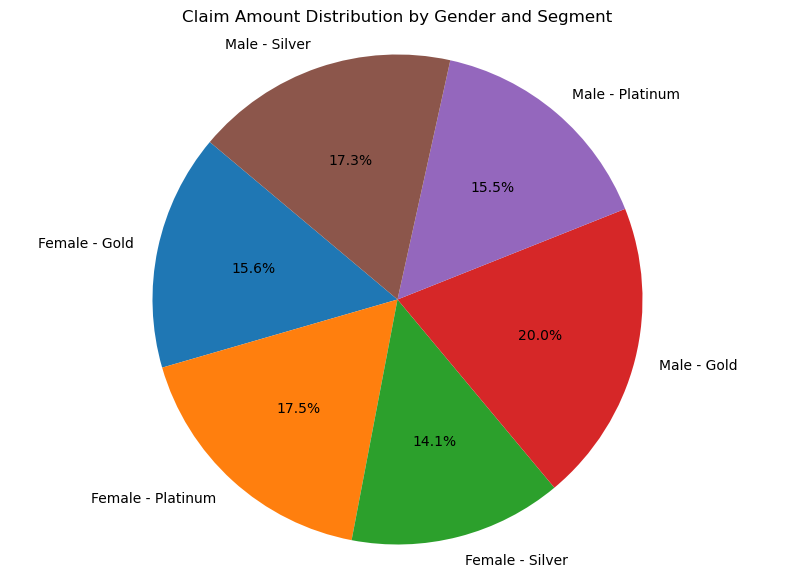

In [19]:
aggregation = df.groupby(['gender', 'Segment'])['claim_amount'].sum().reset_index()
pivot_table = aggregation.pivot(index='gender', columns='Segment', values='claim_amount').fillna(0)
total_claims = pivot_table.sum().sum()

fig, ax = plt.subplots(figsize=(10, 7))
labels = []
sizes = []

for gender in pivot_table.index:
    for segment in pivot_table.columns:
        label = f"{gender} - {segment}"
        labels.append(label)
        sizes.append(pivot_table.loc[gender, segment])

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax.axis('equal') 

plt.title('Claim Amount Distribution by Gender and Segment')
plt.show()

### 12.Among males and females, which gender had claimed the most for anytype of driver related issues? E.g. This metric can be compared using abar chart


In [20]:
df['incident_cause'].unique()

array(['Driver error', 'Crime', 'Other driver error', 'Natural causes',
       'Other causes'], dtype=object)

C:\Users\chitr\AppData\Local\Temp\ipykernel_3868\716460473.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  driver_claims = df[claims_data['incident_cause'].isin(driver_related_issues)]


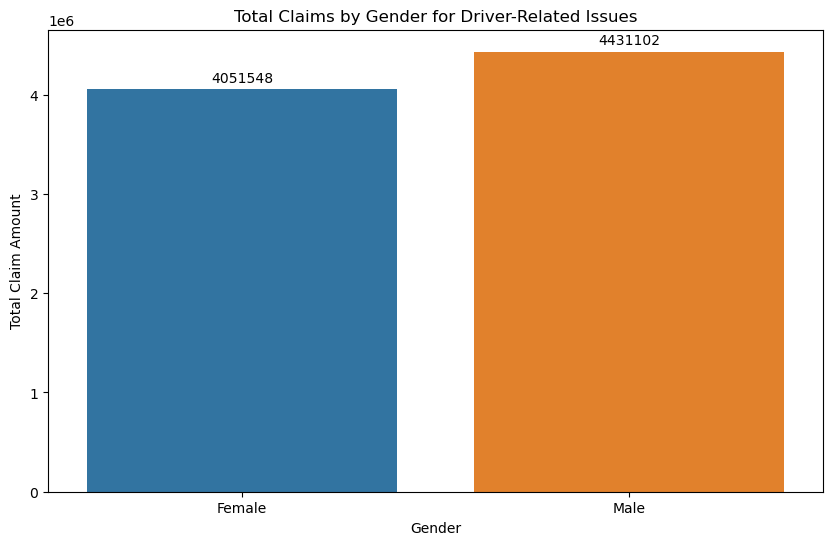

In [21]:
# Filter for driver-related issues 
driver_related_issues = ['Driver error', 'Other driver error', 'Natural causes'] 
driver_claims = df[claims_data['incident_cause'].isin(driver_related_issues)] 

# Group by gender and sum the claim_amount 
gender_claims = driver_claims.groupby('gender')['claim_amount'].sum().reset_index() 

# Plot the bar chart
plt.figure(figsize=(10, 6)) 
ax = sns.barplot(x='gender', y='claim_amount', data=gender_claims) 
plt.title('Total Claims by Gender for Driver-Related Issues') 
plt.xlabel('Gender') 
plt.ylabel('Total Claim Amount')
for container in ax.containers: 
    ax.bar_label(container, label_type='edge', padding=3, fmt='%.0f')
plt.show()

### 13. Which age group had the maximum fraudulent policy claims? Visualize it on a bar chart.

In [22]:
df['age_group'].unique()

array(['Adult', 'Youth', 'Senior'], dtype=object)

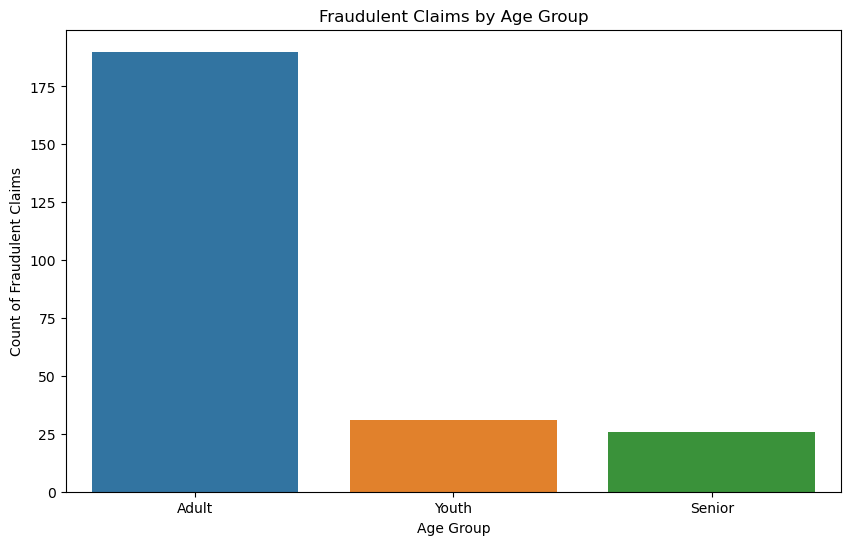

In [23]:
# Filter for fraudulent claims
fraudulent_claims = df[df['fraudulent'] == 'Yes'] 

# Group by age group and count the fraudulent claims 
age_group_fraud = fraudulent_claims['age_group'].value_counts().reset_index() 
age_group_fraud.columns = ['age_group', 'Count']

# Plot the bar chart 
plt.figure(figsize=(10, 6)) 
sns.barplot(x='age_group', y='Count', data=age_group_fraud) 
plt.title('Fraudulent Claims by Age Group') 
plt.xlabel('Age Group') 
plt.ylabel('Count of Fraudulent Claims')
plt.show()

### 14. Visualize the monthly trend of the total amount that has been claimed by the customers. Ensure that on the “month” axis, the month is in a chronological order not alphabetical order.

C:\Users\chitr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\chitr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


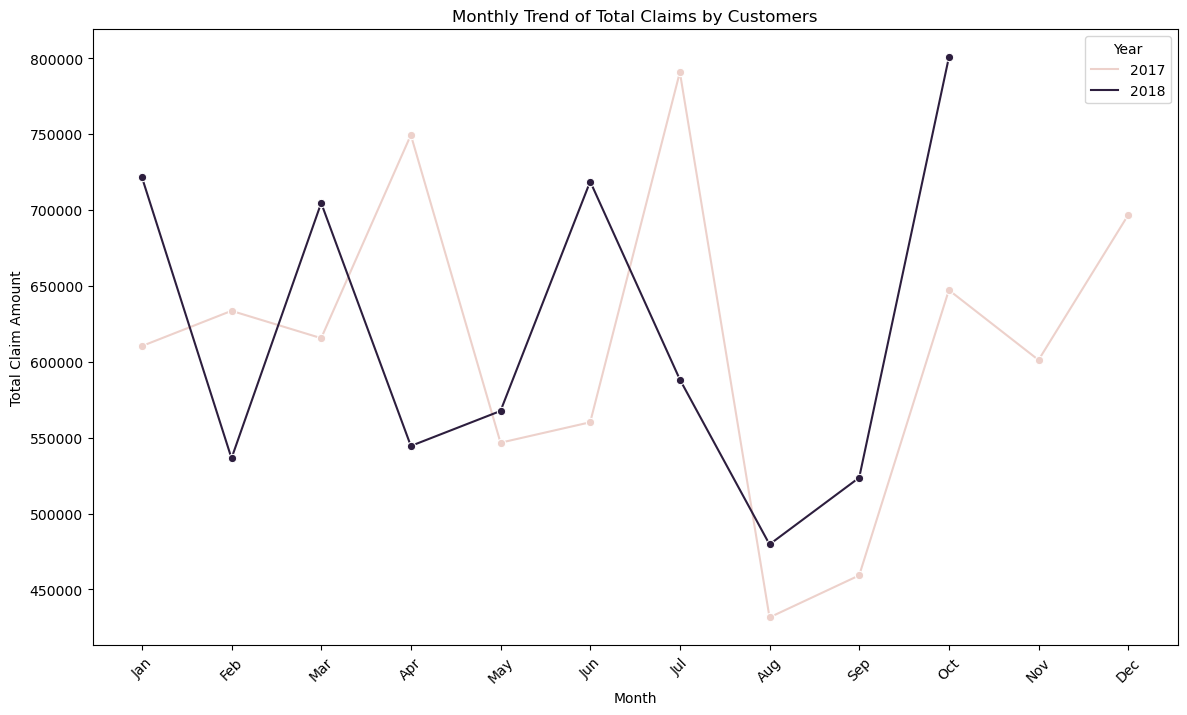

In [24]:
# Convert claim_date to datetime format 
df['claim_date'] = pd.to_datetime(df['claim_date'])

# Extract month and year from claim_date 
df['Month'] = df['claim_date'].dt.strftime('%b')
df['Year'] = df['claim_date'].dt.year

# Convert claim_amount to numeric
df['claim_amount'] = df['claim_amount'].replace('[\$,]', '', regex=True).astype(float) 

# Group by Year and Month and sum the claim_amount 

monthly_claims = df.groupby(['Year', 'Month'])['claim_amount'].sum().reset_index() 

# Sort by Year and Month 
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_claims['Month'] = pd.Categorical(monthly_claims['Month'], categories=month_order, ordered=True) 
monthly_claims = monthly_claims.sort_values(['Year', 'Month']) 

# Plot the line chart 
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_claims, x='Month', y='claim_amount', hue='Year', marker='o') 
plt.title('Monthly Trend of Total Claims by Customers')
plt.xlabel('Month') 
plt.ylabel('Total Claim Amount') 
plt.xticks(rotation=45)
plt.show()

### 15. What is the average claim amount for gender and age categories and suitably represent the above using a facetted bar chart, one facet that represents fraudulent claims and the other for non-fraudulent claims.

<Figure size 1400x800 with 0 Axes>

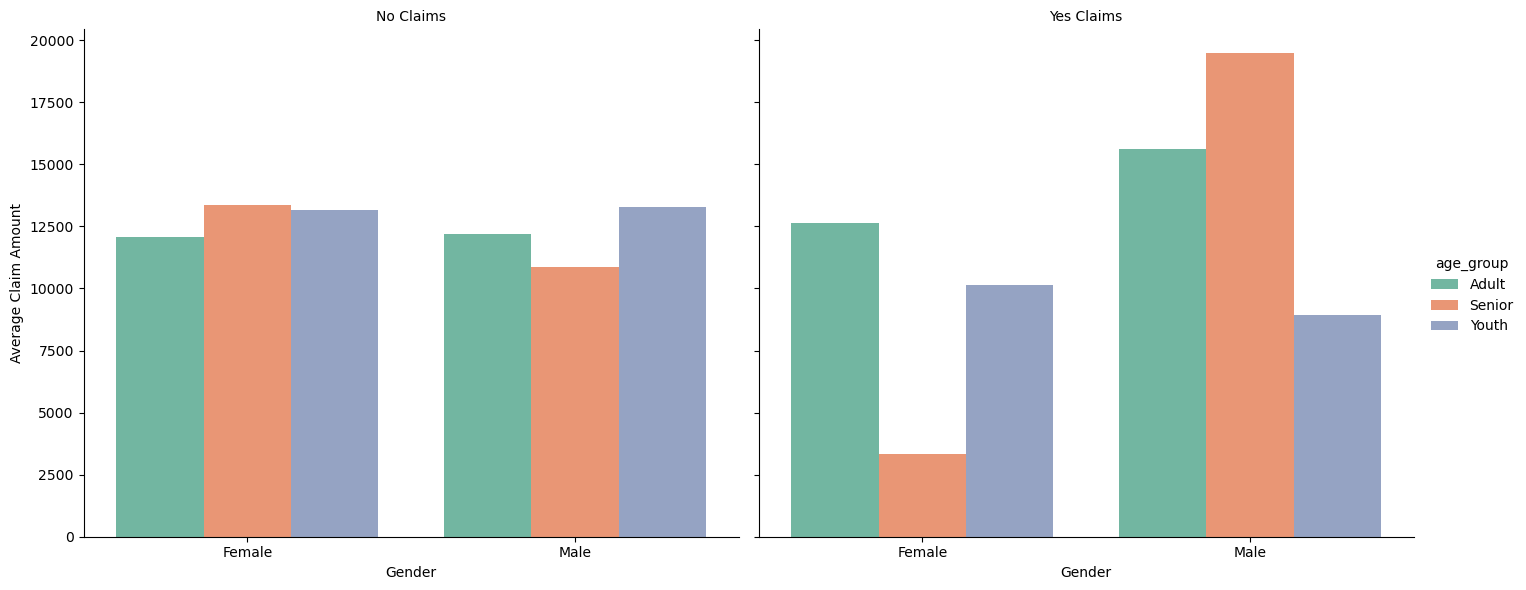

In [25]:
# Group by gender, age category, and fraud status to calculate the average claim amount
avg_claims = df.groupby(['fraudulent', 'gender', 'age_group'])['claim_amount'].mean().reset_index() 

# Plot the facetted bar chart 
plt.figure(figsize=(14, 8)) 
g = sns.catplot(x='gender', y='claim_amount', hue='age_group', col='fraudulent', data=avg_claims, kind='bar', height=6, aspect=1.2, palette='Set2') 
g.set_titles("{col_name} Claims") 
g.set_axis_labels("Gender", "Average Claim Amount")
plt.show()

Based on the conclusions from exploratory analysis as well as suitable
statistical tests, answer the below questions. Please include a detailed
write-up on the parameters taken into consideration, the Hypothesis
testing steps, conclusion from the p-values and the business implications of
the statements. 

### 16. Is there any similarity in the amount claimed by males and females?

Parameters Considered:
Gender (gender)

Claim Amount (claim_amount)

>  Hypothesis Testing:
-  Null Hypothesis (H0): The average claim amount for males and females is the same.
-  Alternative Hypothesis (H1): The average claim amount for males and females is different.

In [26]:
# Filter out claim amounts by gender
male_claims = df[df['gender'] == 'Male']['claim_amount']
female_claims = df[df['gender'] == 'Female']['claim_amount']

# Perform an independent t-test
t_stat, p_value = ttest_ind(male_claims, female_claims)

print("t-statistic:", t_stat)
print("p-value:", p_value)
if p_value < 0.05:
    print("Reject the null hypothesis and conclude thatthere is a significant difference in the average claim amounts between males and females.")
else:
    print("Fail to reject the null hypothesis and conclude that there is no significant difference")


t-statistic: 0.9738138415066818
p-value: 0.33036643165116597
Fail to reject the null hypothesis and conclude that there is no significant difference


### 17. Is there any relationship between age category and segment?17. Is there any relationship between age category and segment?

Parameters Considered:
Age Category (AgeCategory)

Segment (Segment)

>  Hypothesis Testing:
-  Null Hypothesis (H0): Age category and segment are independent.

-  Alternative Hypothesis (H1): Age category and segment are dependent

In [27]:
# Create a contingency table
contingency_table = pd.crosstab(df['age_group'], df['Segment'])

# Perform a chi-square test of independence
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("chi2_stat:", chi2_stat)
print("p-value:", p_value)
if p_value < 0.05:
    print("Reject the null hypothesis and conclude that age category and segment are dependent.")
else:
    print("Fail to reject the null hypothesis and conclude that age category and segment are independet.")

chi2_stat: 0.9329931615944429
p-value: 0.9197804277584449
Fail to reject the null hypothesis and conclude that age category and segment are independet.


### 18. The current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was $10,000.

Parameters Considered:
Claim Amount (claim_amount)

Year

> Hypothesis Testing:
-  Null Hypothesis (H0): The current year's average claim amount is $10,000 (same as 2016-17).

-  Alternative Hypothesis (H1): The current year's average claim amount is different from $10,000.

In [28]:
# Define current_date 
current_date = datetime.now()

# Filter out the current year's claims
current_year_claims = df[df['claim_date'].dt.year == current_date.year]['claim_amount']

# Perform a one-sample t-test
t_stat, p_value = ttest_1samp(current_year_claims, 10000)

print("t-statistic:", t_stat)
print("p-value:", p_value)
if p_value < 0.05:
    print("Reject the null hypothesis and conclude that the current year's average claim amount is significantly different from $10,000.")
else:
    print("Fail to reject the null hypothesis and conclude that there is no significant difference.")

t-statistic: nan
p-value: nan
Fail to reject the null hypothesis and conclude that there is no significant difference.


C:\Users\chitr\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\chitr\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### 19. Is there any difference between age groups and insurance claims?

> Parameters Considered:
- Age Category (AgeCategory)

- Claim Amount (claim_amount)

> Hypothesis Testing:
- Null Hypothesis (H0): The average claim amount is the same across different age groups.

- Alternative Hypothesis (H1): The average claim amount differs across different age groups.

In [29]:
# Filter out claim amounts by age category
children_claims = df[df['age_group'] == 'Children']['claim_amount']
youth_claims = df[df['age_group'] == 'Youth']['claim_amount']
adult_claims = df[df['age_group'] == 'Adult']['claim_amount']
senior_claims = df[df['age_group'] == 'Senior']['claim_amount']

# Perform a one-way ANOVA
f_stat, p_value = f_oneway(children_claims, youth_claims, adult_claims, senior_claims)

print("f-statistic:", f_stat)
print("p-value:", p_value)
if p_value < 0.05:
    print("Reject the null hypothesis and conclude that there are significant differences in average claim amounts across age groups.")
else:
    print("Fail to reject the null hypothesis and conclude that there is no significant difference.")

f-statistic: nan
p-value: nan
Fail to reject the null hypothesis and conclude that there is no significant difference.


C:\Users\chitr\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


### 20. Is there any relationship between total number of policy claims and the claimed amount?

> Parameters Considered:
- Total Policy Claims (total_policy_claims)

- Claim Amount (claim_amount)

> Hypothesis Testing:
- Null Hypothesis (H0): There is no correlation between the total number of policy claims and the claimed amount.

- Alternative Hypothesis (H1): There is a correlation between the total number of policy claims and the claimed amount.

In [30]:
# Calculate the correlation coefficient and p-value
corr_coef, p_value = pearsonr(df['total_policy_claims'], df['claim_amount'])

print("Correlation Coefficient:", corr_coef)
print("p-value:", p_value)
if p_value < 0.05:
    print("Rejectthe null hypothesis and conclude that there is a significant correlation between the total number of policy claims and the claimed amount.")
else:
    print("Fail to reject the null hypothesis and conclude that there is no significant correlation.")

Correlation Coefficient: -0.017448562393468953
p-value: 0.5658830110321474
Fail to reject the null hypothesis and conclude that there is no significant correlation.
